In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th

In [2]:
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return result.tolist()

In [3]:
phantom_data=scipy.io.loadmat('Bay1.mat')

In [4]:
gt = phantom_data["Ground_Truth"]
fmri = phantom_data["fMRI_Output"]

In [5]:
gt_mean = np.mean(gt,axis=1)
fmri_mean = np.mean(gt,axis=1)
gt_std = np.std(gt,axis=1)
fmri_std = np.std(fmri,axis=1)
gt_skew = sp.stats.skew(gt,axis=1)
fmri_skew = sp.stats.skew(fmri,axis=1)

gt_nooutliers = removeOutliers(gt_skew,1.5)
fmri_nooutliers = removeOutliers(fmri_skew,4.0)
print(len(gt_skew)-len(gt_nooutliers),len(fmri_skew)-len(fmri_nooutliers))

7 51


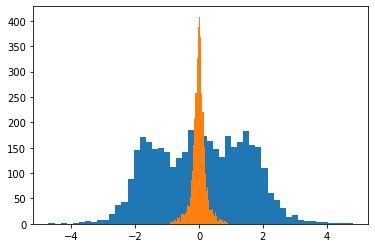

In [6]:
_=plt.hist(gt_nooutliers,bins=50)
_=plt.hist(fmri_nooutliers,bins=50)

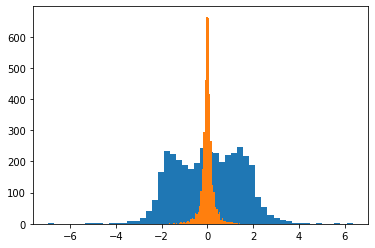

In [7]:
skew_idx = np.argsort(gt_nooutliers)
_=plt.hist(gt_skew,bins=50)
_=plt.hist(fmri_skew,bins=50)

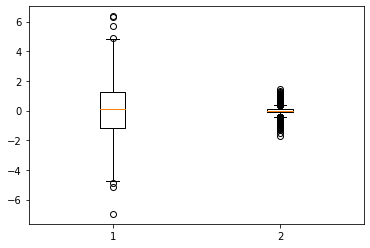

In [8]:
_ = plt.boxplot([gt_skew,fmri_skew])

In [9]:
gt_norm = (gt - gt_mean[:,np.newaxis])/gt_std[:,np.newaxis]
fmri_norm = (fmri - fmri_mean[:,np.newaxis])/fmri_std[:,np.newaxis]

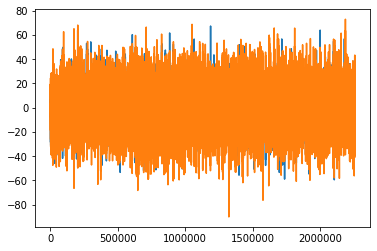

In [10]:
idx = 800
gt_data = gt[skew_idx].flatten()
fmri_data = fmri[skew_idx].flatten()
plt.plot(gt_data)
plt.plot(fmri_data)

In [11]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_signal = pm.Uniform('ampl_signal',0,5)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=ampl_signal*gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=fmri_data)

    posterior_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ampl_noise, ampl_signal, sigma1]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [13:11<00:00,  2.53draws/s] 
The acceptance probability does not match the target. It is 0.8871571538016908, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9008302731354473, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1cabe32fd0>,
      dtype=object)

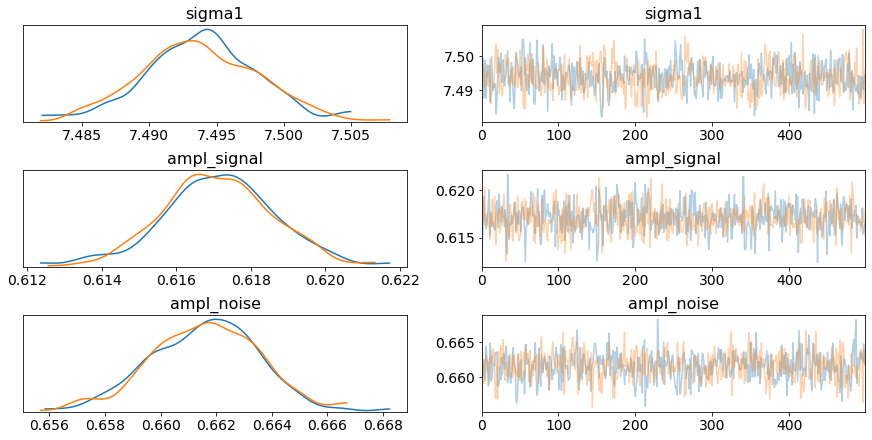

In [14]:
pm.traceplot(posterior_2)

In [13]:
pm.summary(posterior_2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma1,7.494,0.004,7.486,7.502,0.0,0.0,604.0,604.0,605.0,662.0,1.00
ampl_signal,0.617,0.001,0.614,0.620,0.0,0.0,933.0,933.0,932.0,772.0,1.01
ampl_noise,0.662,0.002,0.658,0.665,0.0,0.0,687.0,687.0,691.0,692.0,1.00


In [12]:
# now we want to see what are the contributions to the noise
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
amp_signal = np.mean(posterior_2['ampl_signal'])
sigma_mult = np.sqrt(np.sum(amp_noise**2*gt_data**2)/len(gt_data))
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-amp_signal*gt_data))
print("sigma signal:",np.std(amp_signal*gt_data))
print("signal to noise ratio:",np.std(amp_signal*gt_data)/np.sqrt(sigma_mult**2+sig**2))

sigma mult: 3.3412293132488164
sigma thermal: 7.493765644627456
sigma total noise fitted: 8.204897126735466
sigma total (fmri-gt): 8.150809018123477
sigma signal: 3.1166934701305093
signal to noise ratio: 0.3798577144830782


In [15]:
# here is a more realistic model
#with pm.Model() as multi_noise2:
#    sigma1 = pm.Uniform('sigma1',0,5)
#    ampl1 = pm.Uniform('ampl1',0,5)
#    noise_thermal = pm.Normal('noise_thermal',mu=gt_data, sigma=sigma1,shape=len(gt_data))
#    noise_multi = pm.Normal('noise_multi',mu=0, sigma=ampl1*np.abs(gt_data),shape=len(gt_data))
    
#    fmri = pm.Deterministic('fmri', noise_thermal + noise_multi)
#    fmri_observed = pm.Normal('fmri_observed', mu=fmri, tau=10000,observed=fmri_data)

#    posterior = pm.sample(2000, tune=1000)

In [16]:
#pm.traceplot(posterior['sigma1'])

In [17]:
#pm.traceplot(posterior['ampl1'])